# Population dynamics time-series forecasting for BBS

In [1]:
library(forecast)
library(dplyr)
library(ggplot2)
source("forecast-bbs-core.R")

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: timeDate
This is forecast 6.1 


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Please wait while retriever updates its scripts, ...
The retriever scripts are up-to-date!

  New to ecoretriever? Examples at
    https://github.com/ropensci/ecoretriever/
    Use citation(package='ecoretriever') for the package citation
    
Use suppressPackageStartupMessages() to suppress these messages in the future

Attaching package: ‘ecoretriever’

The following object is masked from ‘package:DBI’:

    fetch



## Forecast population time-series

These data structures are then cached, so if the files exist this step can be skipped.

In [ ]:
# Add zeros to population time-series data
pop_dyn <- contig_ts_long %>%
    tbl_df() %>%
    select(site_id, year, species_id, abundance) %>%
    group_by(site_id) %>%
    do(get_popdyn_data_w_zeros(., min(.$year), max(.$year))) %>%
    arrange(site_id, year, species_id)
head(pop_dyn)

In [ ]:
# Forecast
popdyn_ts_forecasts <- get_ts_forecasts(group_by(pop_dyn, site_id, species_id), timecol = "year", responsecol = "abundance", lag = 5)
save(popdyn_ts_forecasts, file = "popdyn_ts_forecasts.RData")
popdyn_ts_forecasts_clean <- cleanup_multi_ts_forecasts(popdyn_ts_forecasts, c('site_id', 'species_id'))
save(popdyn_ts_forecasts_clean, file = "popdyn_ts_forecasts_clean.RData")

## Run analyses on forecasts

In [2]:
load("popdyn_ts_forecasts.RData")

In [3]:
head(popdyn_ts_forecasts, 1)

,site_id,species_id,timeperiod,cast_naive,cast_avg,cast_arima,test_set
1,2002,1440,"1990, 1991, 1992, 1993, 1994","Naive method, 0.5714286, -15.94783, 33.89566, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, -1, 0, 2, -1, -1, 0, 0, 0, 0, Arima(x = x, order = c(0, 1, 0), lambda = lambda), x, 0, 0, 14, 1, 1, 1, 0, 0, 0, -7.420876e-23, -7.420876e-23, 7.420876e-23, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 7.420876e-23, 34.22899, 34.53472, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 80, 95, 0, 0, 0, 0, 0, -0.9687619, -1.370036, -1.677945, -1.937524, -2.166218, -1.481594, -2.09529, -2.566195, -2.963187, -3.312944, 0.9687619, 1.370036, 1.677945, 1.937524, 2.166218, 1.481594, 2.09529, 2.566195, 2.963187, 3.312944, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, structure(c(0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0), .Tsp = c(1, , 15, 1), class = ""ts""), NA, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, NA, 0, 0, 0, 0, 1, -1, 0, 2, -1, -1, 0, 0, 0, 0","Mean, 80, 95, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, .[[responsecol]][1:(length(.[[responsecol]]) - lag)], 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, -0.5579511, -0.5579511, -0.5579511, -0.5579511, -0.5579511, -1.04827, -1.04827, -1.04827, -1.04827, -1.04827, 1.091284, 1.091284, 1.091284, 1.091284, 1.091284, 1.581603, 1.581603, 1.581603, 1.581603, 1.581603, 0.2666667, 0.1532712, 0.5936168, meanf(x = .[[responsecol]][1:(length(.[[responsecol]]) - lag)], , h = lag), 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, -0.2666667, -0.2666667, -0.2666667, -0.2666667, -0.2666667, 0.7333333, -0.2666667, -0.2666667, 1.733333, 0.7333333, -0.2666667, -0.2666667, -0.2666667, -0.2666667, -0.2666667","ARIMA(0,0,0) with non-zero mean, 0.2666667, 0.3288889, 0.02192615, TRUE, -12.94381, 29.88763, 0, 0, 0, 0, 1, 0, 0, -0.2666667, -0.2666667, -0.2666667, -0.2666667, -0.2666667, 0.7333333, -0.2666667, -0.2666667, 1.733333, 0.7333333, -0.2666667, -0.2666667, -0.2666667, -0.2666667, -0.2666667, auto.arima(x = structure(list(x = structure(c(0, 0, 0, 0, 0, , 1, 0, 0, 2, 1, 0, 0, 0, 0, 0), .Tsp = c(1, 15, 1), class = ""ts"")), .Names = ""x"", row.names = c(NA, , -15L), class = ""data.frame""), seasonal = FALSE), .[[responsecol]][1:(length(.[[responsecol]]) - lag)], 0, 0, 15, 1, -0.2666667, 0, 0, 1, 0, 1, 31.30373, 30.88763, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 80, 95, 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, -0.4682882, -0.4682882, -0.4682882, -0.4682882, -0.4682882, -0.8573498, -0.8573498, -0.8573498, -0.8573498, -0.8573498, 1.001622, 1.001622, 1.001622, 1.001622, 1.001622, 1.390683, 1.390683, 1.390683, 1.390683, 1.390683, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, structure(c(0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0), .Tsp = c(1, , 15, 1), class = ""ts""), 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, 0.2666667, -0.2666667, -0.2666667, -0.2666667, -0.2666667, -0.2666667, 0.7333333, -0.2666667, -0.2666667, 1.733333, 0.7333333, -0.2666667, -0.2666667, -0.2666667, -0.2666667, -0.2666667","0, 0, 0, 0, 0"


In [4]:
load("popdyn_ts_forecasts_clean.RData")

In [5]:
head(popdyn_ts_forecasts_clean)

,model,timeperiod,obs,pt_fcast,lo80,hi80,lo95,hi95,site_id,species_id
1,naive,1990,0,0,-0.9687619,0.9687619,-1.481594,1.481594,2002,1440
2,naive,1991,0,0,-1.370036,1.370036,-2.09529,2.09529,2002,1440
3,naive,1992,0,0,-1.677945,1.677945,-2.566195,2.566195,2002,1440
4,naive,1993,0,0,-1.937524,1.937524,-2.963187,2.963187,2002,1440
5,naive,1994,0,0,-2.166218,2.166218,-3.312944,3.312944,2002,1440
6,avg,1990,0,0.2666667,-0.5579511,1.091284,-1.04827,1.581603,2002,1440


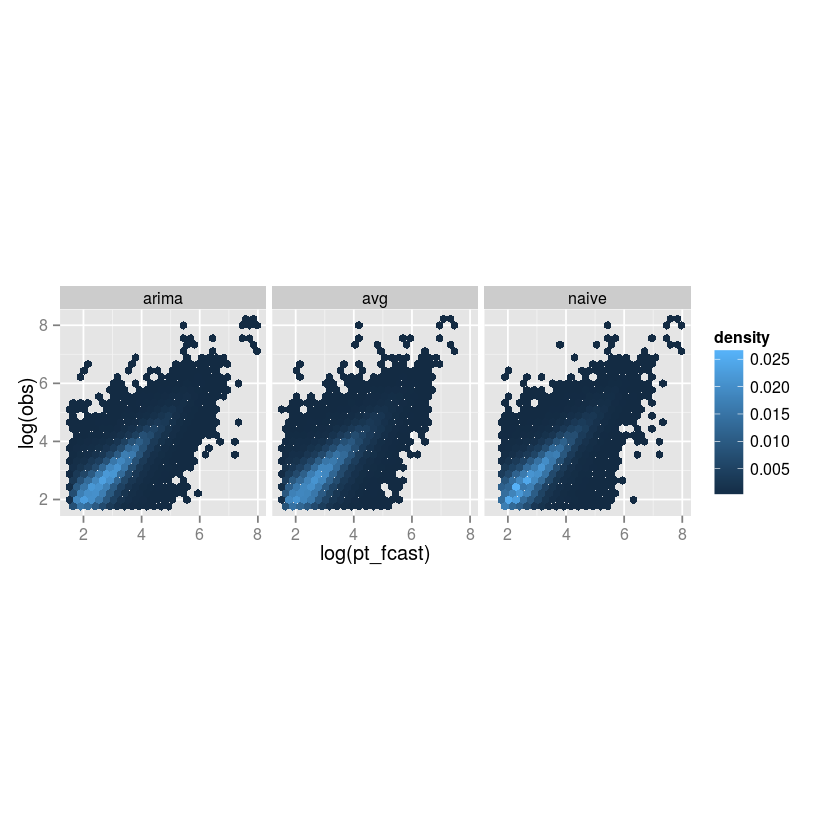

In [6]:
popdyn_ts_forecasts_clean_min <- filter(popdyn_ts_forecasts_clean, obs > 5, pt_fcast > 5)
ggplot(popdyn_ts_forecasts_clean_min, aes(x = log(pt_fcast), y = log(obs), fill = ..density..)) +
    stat_binhex(na.rm = TRUE, bins=25) +
    facet_wrap(~ model) +
    theme(aspect.ratio = 1)

In [ ]:
model_accuracies <- group_by(popdyn_ts_forecasts_clean, site_id, species_id, model) %>%
                    do(get_error_measures(.$obs, .$pt_fcast))
head(model_accuracies)

Warning message:
: Grouping rowwise data frame strips rowwise nature

In [ ]:
save(model_accuracies, file = "popdyn_model_accuracies.RData")

In [ ]:
#model_accuracies$model = with(model_accuracies, factor(model, levels = c("arima", "avg", "naive")))
ggplot(model_accuracies, aes(model, MAPE)) +
     geom_violin(aes(fill = model)) + coord_cartesian(ylim = c(0,1000)) +
     labs(x = "Model", y = "Percentage Error") +
     scale_x_discrete(labels=c("Time-\nseries", "Average", "Naive")) +
     theme_grey(base_size = 24) +
     guides(fill=FALSE)